# Sect 38: Time Series Models

- 10/16/20
- online-ds-ft-070620

## Learning Objectives:

- Revisit types of time series trends and how to remove them.
- Revisit seasonal decomposition`statsmodels.tsa.seasonal.seasonal_decompose`

- Learn about PACF, ACF
- Introduce ARIMA and SARIMA models.
- Activity: SARIMA Models - Lab




## Questions

### New Questions
- How do you decide how many lags to plot for ACF/PACF
- Extra explanation of the ARMA readme.  
- Explanation of how to read the autocorrelation and partial autocorrelation plots
- Everything in the ARMA  models readme went right over my head
- APPENDIX SARIMA


#### Other Questions
- Big Picture Questions about the Appendix

## References

- [Pandas Timeseries Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- ['Timeseries Offset Aliases'](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)
- [Anchored Offsets](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets)


- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

# Sect 38: TIME SERIES MODELS

## Reviewing the End of Sect 37

In [1]:
from fsds.imports import *
pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = (12,6)

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
df = pd.read_csv('baltimore_crime_2020_ts_070620ft.csv',
                 index_col=0,parse_dates=[0])
## Lazy fix to not changine col names to lowercase last class
df.columns = [col.lower() for col in df.columns]
df.index.freq = 'D'
display(df.head())

df.index

,burglary,common assault,larceny,robbery - street,auto theft,agg. assault,larceny from auto,shooting,robbery - residence,robbery - commercial,arson,homicide,robbery - carjacking,rape
2014-01-01,20,19,34,8,9,22,15,2,1,2,2.0,2.0,1.0,4.0
2014-01-02,28,23,26,4,7,6,10,0,1,1,2.0,3.0,1.0,0.0
2014-01-03,13,17,16,2,3,11,6,1,1,1,2.0,1.0,0.0,0.0
2014-01-04,20,23,23,7,14,14,15,0,1,1,2.0,0.0,0.0,0.0
2014-01-05,14,22,19,10,11,9,13,2,1,0,2.0,0.0,2.0,1.0


DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25'],
              dtype='datetime64[ns]', length=2307, freq='D')

[Text(0.5, 1.0, 'Baltimore Crime Rates - <Day>')]

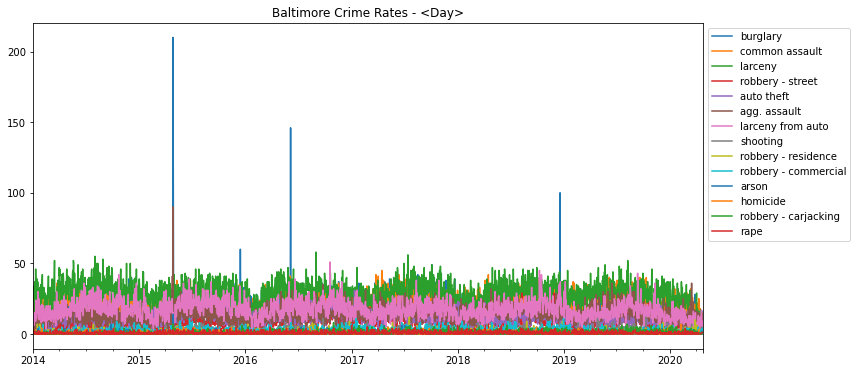

In [3]:
ax = df.plot()
ax.legend(bbox_to_anchor=([1,1]))
ax.set(title=f'Baltimore Crime Rates - {df.index.freq}')

# Trends/Stationarity

<div style="text-align:center;font-size:2em">Trends</div>
<img src="https://raw.githubusercontent.com/learn-co-students/dsc-removing-trends-online-ds-ft-100719/master/images/new_trendseasonal.png" width=80%>

<div style="text-align:center;font-size:2em">Mean</div>
    
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_mean_nonstationary.png" width=70%>
<br><br>
<div style="text-align:center;font-size:2em">Variance</div>
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_cov_nonstationary.png" width=70%>
</div>

<AxesSubplot:>

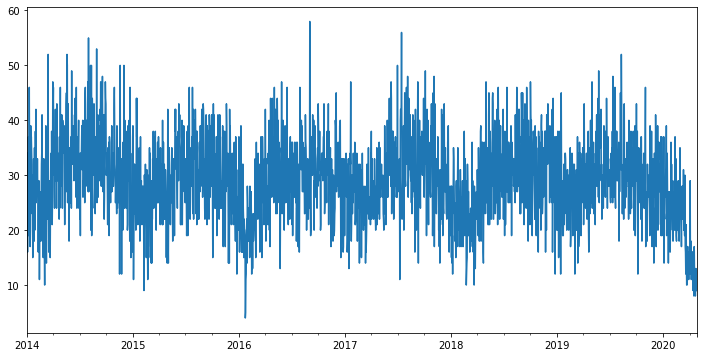

In [4]:
## Pick a time series from above to work with
ts = df['larceny']
ts.plot()

### Testing for Stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(TS,plot=True,col=None):
    """From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    """
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    if col is not None:
        # Perform the Dickey Fuller Test
        dftest = adfuller(TS[col]) # change the passengers column as required 
    else:
        dftest=adfuller(TS)
 
    if plot:
        # Calculate rolling statistics
        rolmean = TS.rolling(window = 8, center = False).mean()
        rolstd = TS.rolling(window = 8, center = False).std()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    dfoutput['stationary?'] = dfoutput['p-value']<.05

    print (dfoutput)
    
    return dfoutput

In [6]:
## Simpler Version of ADfullter func
def adfuller_test_df(ts):
    """Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    df_res = adfuller(ts)
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    return pd.DataFrame(res,index=['AD Fuller Results'])
adfuller_test_df(ts)


,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-2.786,0.06,27,2279,False,False


Results of Dickey-Fuller Test:
Test Statistic                   -2.786
p-value                           0.060
#Lags Used                       27.000
Number of Observations Used    2279.000
Critical Value (1%)              -3.433
Critical Value (5%)              -2.863
Critical Value (10%)             -2.567
stationary?                       0.000
dtype: float64


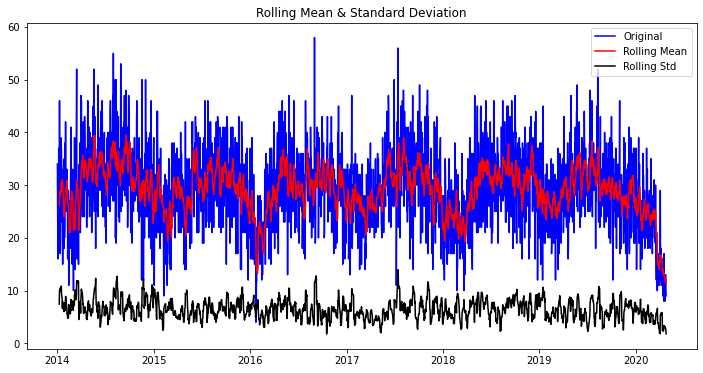

In [7]:
stationarity_check(ts);

## Removing Trends 

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-2.786,0.06,27,2279,False,False


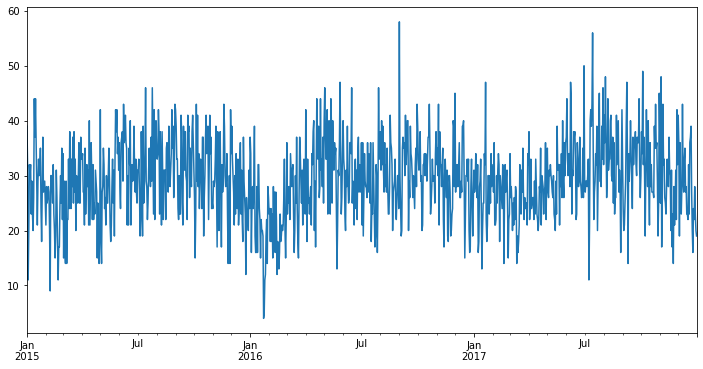

In [8]:
## Combine methods above into one DF
ts.loc['2015':'2017'].plot()

adfuller_test_df(ts)

#### Trend Removal Methods
- Differencing (`.diff()`)
- Log-Transformation (`np.log`)
- Subtract Rolling Mean (`ts-ts.rolling().mean()`)
- Subtract Exponentially-Weighted Mean (`ts-ts.ewm().mean()`)
- Seasonal Decomposition (`from statsmodels.tsa.seasonal import seasonal_decompose`
)

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-13.983,4.141e-26,26,2279,True,True


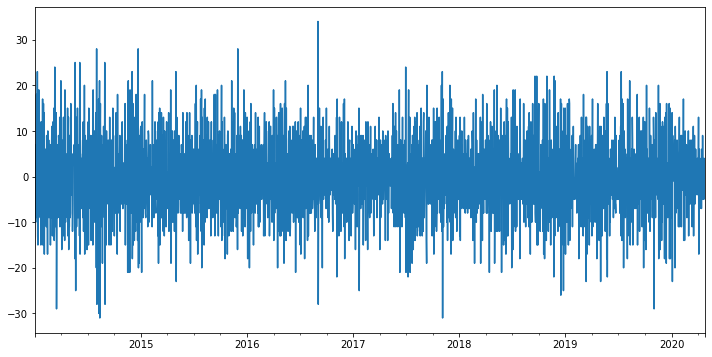

In [9]:
## Differencing 
ts0 = ts.diff().dropna()
ts0.plot()
adfuller_test_df(ts0)

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-1.898,0.333,27,2279,False,False


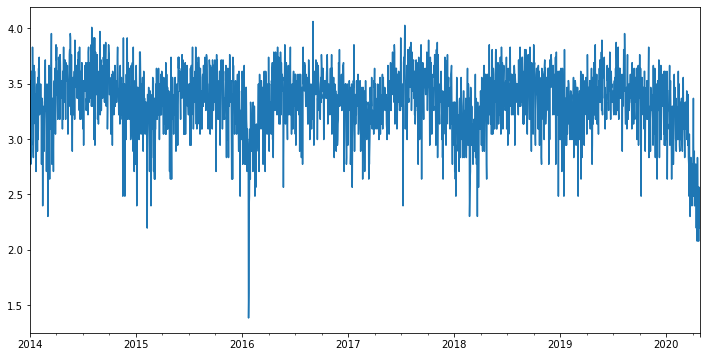

In [10]:
## Log Transform
ts3 = np.log(ts)
ts3.plot()
adfuller_test_df(ts3)

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-14.117,2.462e-26,26,2278,True,True


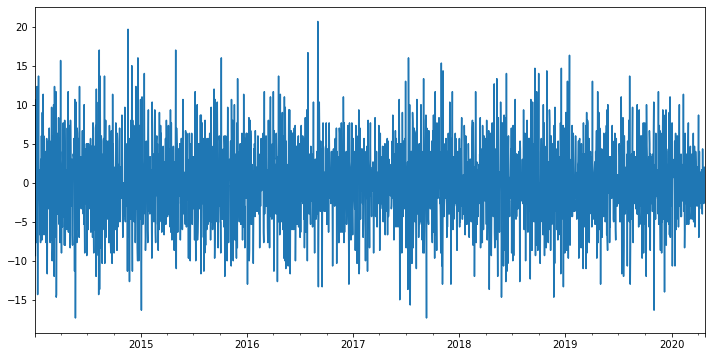

In [11]:
## Subtract Rolling mean
ts2 = (ts - ts.rolling(3).mean()).dropna()
ts2.plot()
adfuller_test_df(ts2)

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-9.207,1.931e-15,27,2279,True,True


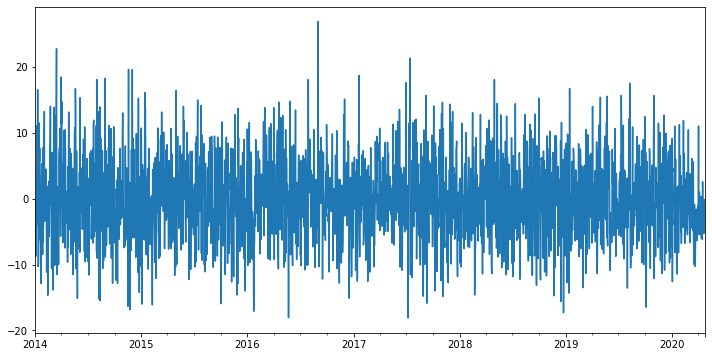

In [12]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (ts - ts.ewm(halflife=7).mean()).dropna()
ts4.plot()
adfuller_test_df(ts4)

## Seasonal Decomposition

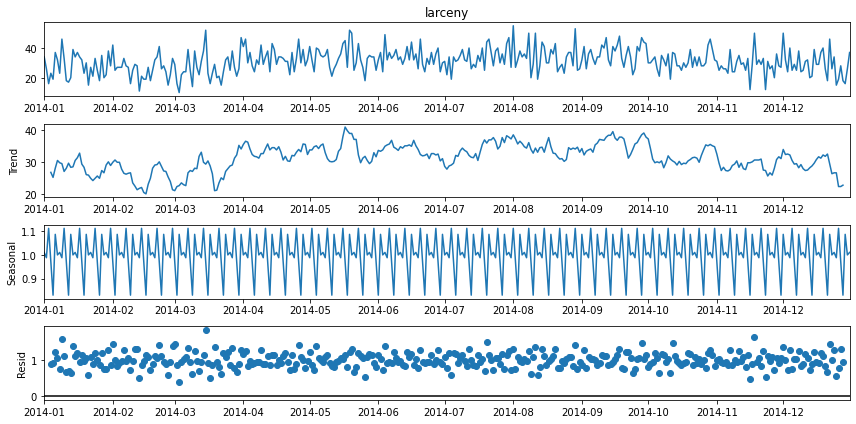

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_mul = seasonal_decompose(ts.loc['2014'],model='mul')#,model='mul')
decomp_mul.plot();

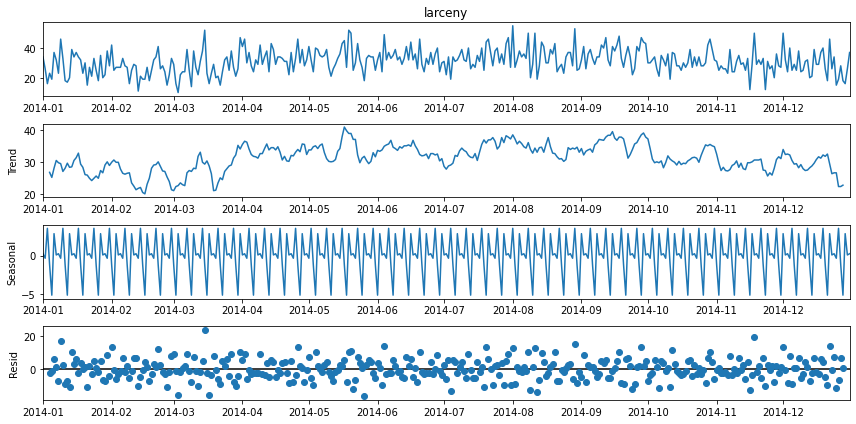

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts.loc['2014'])
decomp.plot();

<AxesSubplot:>

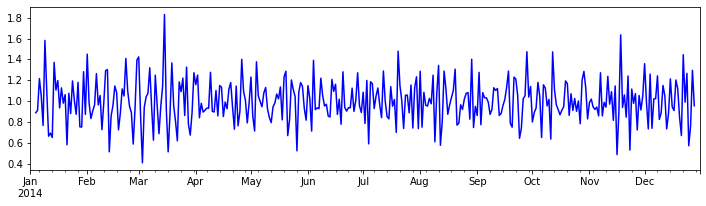

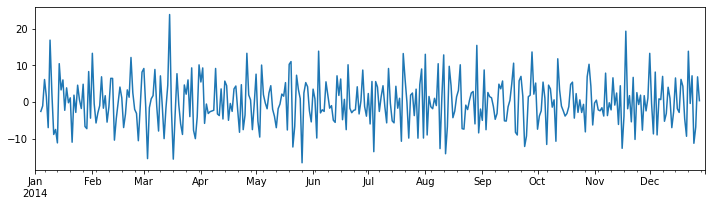

In [15]:
plt.rcParams['figure.figsize'] = [12,3]
decomp_mul.resid.plot(label='mul',color='blue')
plt.figure()
decomp.resid.plot()

,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-6888994913966402.000,0.000,12,352,True,True


,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-1.489,0.539,15,343,False,False


,Test Statistic,p-value,#Lags Used,# of Observations Used,p<.05,Stationary?
AD Fuller Results,-9.438,0.000,17,341,True,True


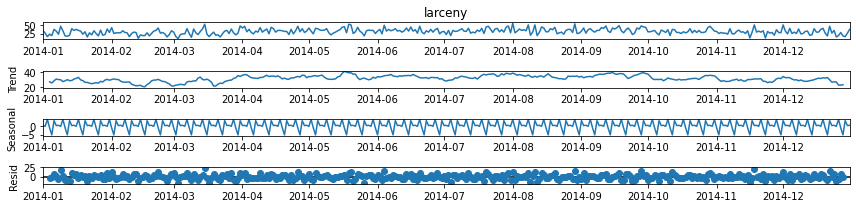

In [16]:
seasons = {'seasonal':decomp.seasonal,
          'trend':decomp.trend,
          'resid':decomp.resid}
for data,ts_ in seasons.items():
    ts_ = ts_.dropna()
#     ts_.plot(title=data)
    plt.show()
    display(adfuller_test_df(ts_).style.set_caption(data))
decomp.plot();

# Basic Time Series models

- White Noise Model
- Randon Walk Model

#### White Noise Model
- 3 Properties:
    - Fixed and constant mean
    - Fixed and constant variance
    - No correlation over time

- Gaussian White Noise: A special case of a White Noise model is 
    - Mean is equal to zero
    - variance is equal to 1
    $$\large Y_t = \epsilon_t + \theta * \epsilon_{t-1}$$


In [17]:
plt.rcParams['figure.figsize'] = [12,4]

monthly_return    0.014
dtype: float64

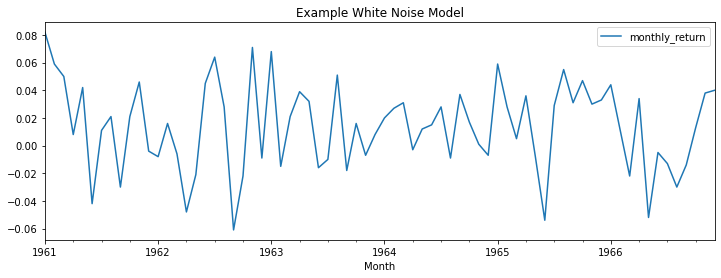

In [18]:

nyse = fs.datasets.load_ts_nyse_monthly(read_csv_kwds={'parse_dates':True,
                                                     'index_col':'Month'})
nyse.plot(title='Example White Noise Model')
nyse.mean()


#### Random Walk Model
- Two Properties:
    - Has no specified mean or variance
    - Has a strong dependence over time

- Mathematically, this can be written as:

$$\large Y_t = Y_{t-1} + \epsilon_t$$

- Where $\epsilon_t$ is a *mean zero* white noise model!

- Random Walk with a Drift":
    - a drift parameter $c$, steering in a certain direction.
$$\large Y_t = c + Y_{t-1} + \epsilon_t$$

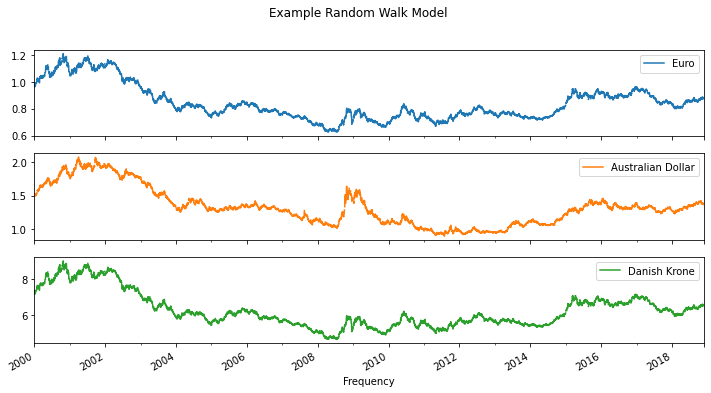

In [19]:
exch = fs.datasets.load_ts_exch_rates(read_csv_kwds={'parse_dates':['Frequency'],
                                                     'index_col':'Frequency'})
exch.plot(subplots=True,figsize=(12,6),title='Example Random Walk Model');

- When a random walk is differenced it returns a white noise. 

This is a result of the mathematical formula:

$$Y_t = Y_{t-1} + \epsilon_t$$
which is equivalent to
$$Y_t - Y_{t-1} = \epsilon_t$$

and we know that $\epsilon_t$ is a mean-zero white noise process! 

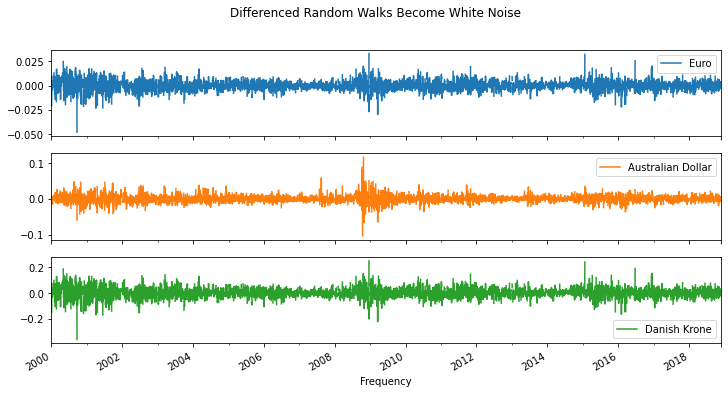

In [20]:
exch.diff().plot(subplots=True,figsize=(12,6),
                 title='Differenced Random Walks Become White Noise');


# Correlation, Autocorrelation & Partial Autocorrelation

<AxesSubplot:xlabel='Month'>

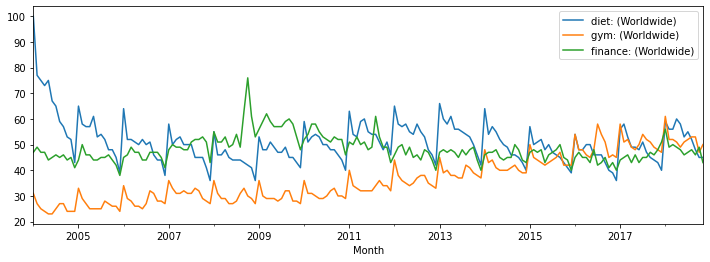

In [21]:
trends = fs.datasets.load_ts_google_trends(read_csv_kwds={'skiprows':1,
                                                         'parse_dates':['Month'],
                                                         'index_col':['Month']})
trends.plot()

In [22]:
## Correlation
trends.corr().style.background_gradient()

,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
diet: (Worldwide),1.000,-0.051,-0.027
gym: (Worldwide),-0.051,1.000,-0.223
finance: (Worldwide),-0.027,-0.223,1.000


,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
diet: (Worldwide),1.000,0.793,0.395
gym: (Worldwide),0.793,1.000,0.342
finance: (Worldwide),0.395,0.342,1.000


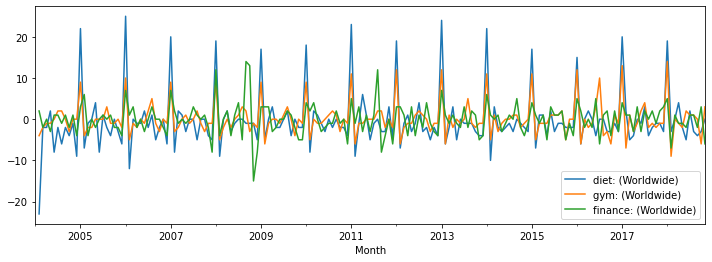

In [23]:
## Detrending Reveals Higher Underly Cross-Correlation
trends.diff().plot()
trends.diff().corr().style.background_gradient()
## We Removed the Trend without Removing Seaonality

<ipython-input-24-ab19ae076419>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_shifted[f"Shifted by {n}"] = ts_shifted.shift(n)


<AxesSubplot:xlabel='Month'>

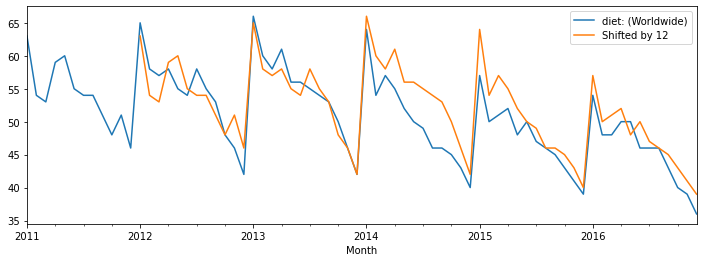

In [24]:
## Seasonality causes correlations at specific times
n=12
ts = trends[['diet: (Worldwide)']]
ts_shifted = ts.loc['2011':'2016']
ts_shifted[f"Shifted by {n}"] = ts_shifted.shift(n)
ts_shifted.plot()

### Demonstrating Autocorrelation

<AxesSubplot:xlabel='Month'>

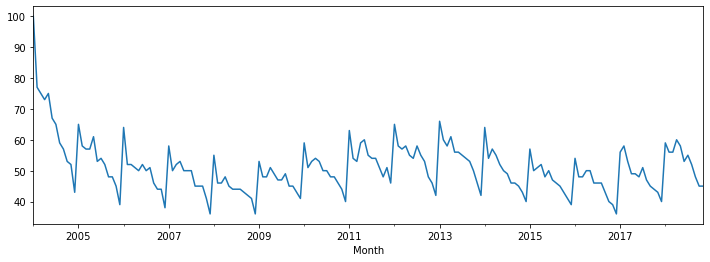

In [25]:
ts = trends['diet: (Worldwide)']
ts.plot()

In [26]:
ts

Month
2004-01-01    100
2004-02-01     77
2004-03-01     75
2004-04-01     73
2004-05-01     75
             ... 
2018-07-01     55
2018-08-01     52
2018-09-01     48
2018-10-01     45
2018-11-01     45
Name: diet: (Worldwide), Length: 179, dtype: int64

In [27]:
ts.shift(1)

Month
2004-01-01      NaN
2004-02-01    100.0
2004-03-01     77.0
2004-04-01     75.0
2004-05-01     73.0
              ...  
2018-07-01     53.0
2018-08-01     55.0
2018-09-01     52.0
2018-10-01     48.0
2018-11-01     45.0
Name: diet: (Worldwide), Length: 179, dtype: float64

In [28]:
## Generate 6 time-shifted columns
total_shifts = 6
shifts = [ts.shift(x).rename(f"Diet shifted {x}") for x in range(total_shifts)]
res = pd.concat(shifts,axis=1)
res

,Diet shifted 0,Diet shifted 1,Diet shifted 2,Diet shifted 3,Diet shifted 4,Diet shifted 5
Month,,,,,,
2004-01-01,100,NaN,NaN,NaN,NaN,NaN
2004-02-01,77,100.0,NaN,NaN,NaN,NaN
2004-03-01,75,77.0,100.0,NaN,NaN,NaN
2004-04-01,73,75.0,77.0,100.0,NaN,NaN
2004-05-01,75,73.0,75.0,77.0,100.0,NaN
...,...,...,...,...,...,...
2018-07-01,55,53.0,58.0,60.0,56.0,56.0
2018-08-01,52,55.0,53.0,58.0,60.0,56.0
2018-09-01,48,52.0,55.0,53.0,58.0,60.0


<AxesSubplot:xlabel='Month'>

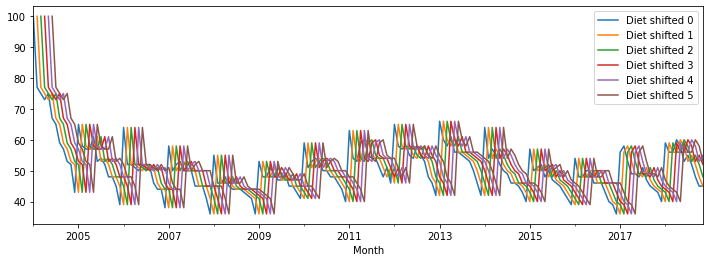

In [29]:
res.plot()

In [30]:
res.corr()['Diet shifted 0']

Diet shifted 0    1.000
Diet shifted 1    0.625
Diet shifted 2    0.538
Diet shifted 3    0.444
Diet shifted 4    0.313
Diet shifted 5    0.204
Name: Diet shifted 0, dtype: float64

In [31]:
total_shifts = 160
shifts = [ts.shift(x).rename(f"Diet shifted {x}") for x in range(total_shifts)]
res = pd.concat(shifts,axis=1)
res

,Diet shifted 0,Diet shifted 1,Diet shifted 2,Diet shifted 3,Diet shifted 4,Diet shifted 5,Diet shifted 6,Diet shifted 7,Diet shifted 8,Diet shifted 9,...,Diet shifted 150,Diet shifted 151,Diet shifted 152,Diet shifted 153,Diet shifted 154,Diet shifted 155,Diet shifted 156,Diet shifted 157,Diet shifted 158,Diet shifted 159
Month,,,,,,,,,,,,,,,,,,,,,
2004-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,77,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,75,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,73,75.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,75,73.0,75.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-01,55,53.0,58.0,60.0,56.0,56.0,59.0,40.0,43.0,44.0,...,64.0,39.0,45.0,48.0,48.0,52.0,54.0,53.0,61.0,57.0
2018-08-01,52,55.0,53.0,58.0,60.0,56.0,56.0,59.0,40.0,43.0,...,52.0,64.0,39.0,45.0,48.0,48.0,52.0,54.0,53.0,61.0
2018-09-01,48,52.0,55.0,53.0,58.0,60.0,56.0,56.0,59.0,40.0,...,52.0,52.0,64.0,39.0,45.0,48.0,48.0,52.0,54.0,53.0


<AxesSubplot:>

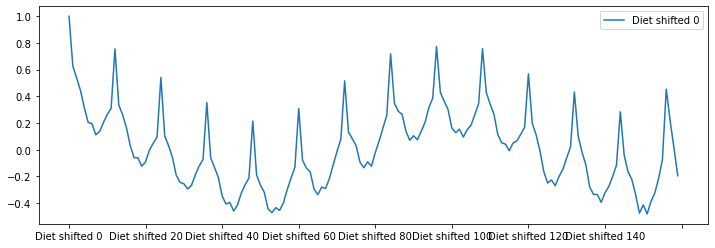

In [32]:
res.corr()[['Diet shifted 0']].plot()

## ACF & PACF  Plots

### Autocorrelation Function Plots

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

> - "The **autocorrelation function** is a function that represents autocorrelation of a time series as a function of the time lag."
- The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.



<AxesSubplot:>

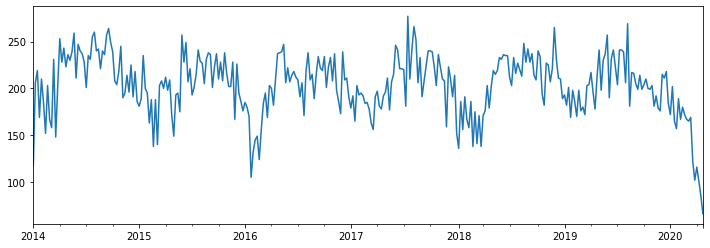

In [33]:
ts = df['larceny'].resample('W').sum()
ts.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

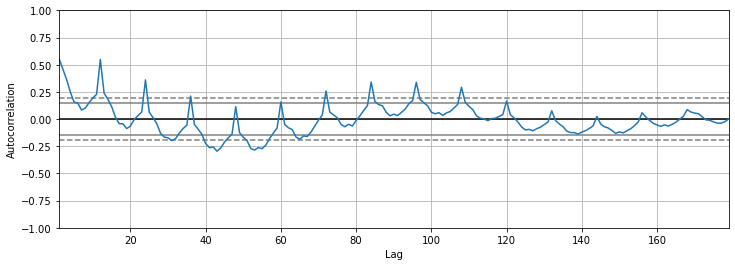

In [34]:
ts= trends['diet: (Worldwide)']

pd.plotting.autocorrelation_plot(ts)

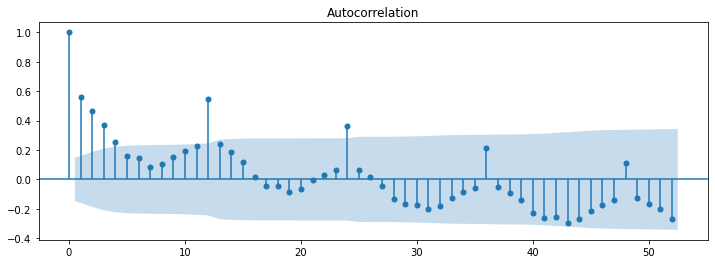

In [35]:
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(ts,lags=52);

### Partial-Autocorrelation Function Plot


> "The **partial autocorrelation function** can be interpreted as a regression of the series against its past lags.
 
 > It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. "

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 160 must be < 89.

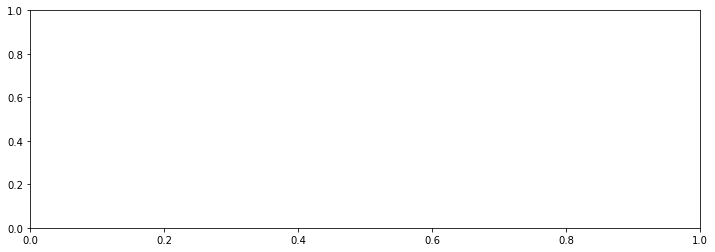

In [36]:
tsa.plot_pacf(ts,lags=160);

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# mpl.rcParams['figure.figsize'] = (12,4)
plot_acf(ts);
plot_pacf(ts);

#  ARMA MODELS


## Autoregressive Model (AR)



An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

In words, the mathematical idea is the following:

$$ \text{Today = constant + slope} \times \text{yesterday + noise} $$

Or, mathematically:
$$\large Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follows an oscillatory process

<!---

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_model.png">

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_PACF.png"> --->

## The  Moving Average Model




The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

In words, the mathematical idea is the following:

$$ \text{Today = Mean + Noise + Slope} \times \text{yesterday's noise} $$

Or, mathematically:
$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated and depends on the previous white noise process
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follow an oscillatory process


## Higher-order AR and MA models




Let's look at the formulas of AR and MA again:

- AR: $Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$
- MA: $Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$

Note that these models are constructed in a way that processes only depend directly on the previous observation in the process. These models are so-called "1st order models", and denoted by AR(1) and MA(1) processes respectively. Let's look at AR(2) and MA(2).

- AR(2): $$Y_t = \mu + \phi_1 * Y_{t-1}+\phi_2 * Y_{t-2}+\epsilon_t$$
- MA(2): $$Y_t = \mu +\epsilon_t + \theta_1 * \epsilon_{t-1}+ \theta_2 * \epsilon_{t-2}$$



___

# ARIMA MODELS:


## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

### Number of AR (Auto-Regressive) terms (p): 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q): 

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## READING PACF/ACF FOR AR/MA MODEL ORDERS

INFO FROM UDEMY

- **USE ACF TO JUDGE IF MA OR AR COMPONENTS:**
    - If lag 1 is positive: AR
    - If lag 1 is negatige: MA
    
- **PACF is best for picking AR (p)**
- **ACF is best for picking MA(q)**
    - If sharp drop off at lag of k (k= point on x axis) means use an AR model of order k.
    - If slow gradual decline: use MA
    
    
___
INFO FROM LESSONS:

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |
  
#### Note on modeling

Seeing the table above, you might get an idea of why ACF and PACF are so useful when modeling! What you generally will try to do for any time series analysis is:

- Detrend your time series using differencing. ARMA models represent stationary processes, so we have to make sure there are no trends in our time series
- Look at ACF and PACF of the time series
- Decide on the AR, MA, and order of these models
- Fit the model to get the correct parameters and use for prediction

In [ ]:
plot_acf(ts);
plot_pacf(ts);

# Activity: SARIMA Lab

- Repo folder > labs from class> sect_38

# Appendix

In [ ]:
stop

## `pmdarima.auto_arima`

In [ ]:
# !pip install -U pmdarima
import pmdarima
pmdarima.auto_arima?


## Remaining Questions from Sect 37

### Loading the Dataset From Last Class

In [ ]:
from fsds.imports import *
pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = (12,6)

In [ ]:
df = pd.read_csv('../baltimore_crime_2020_ts_070620ft.csv',
                 index_col=0,parse_dates=[0])
## Lazy fix to not changine col names to lowercase last class
df.columns = [col.lower() for col in df.columns]
df.index.freq = 'D'
display(df.head())

df.index

In [ ]:

df.head()

In [ ]:
df.isna().sum()

In [ ]:
ax = df.plot()
ax.legend(bbox_to_anchor=([1,1]))
ax.set(title=f'Baltimore Crime Rates - {df.index.freq}')

In [ ]:
def ts_plot(df,title=f'Baltimore Crime Rates'):
    ax = df.plot()
    ax.get_legend().set_bbox_to_anchor([1,1])
    ax.set(title=title)
    fig = ax.get_figure()
    # fig = plt.gcf()
    return fig,ax

In [ ]:
# ts_plot(df,title='Baltimore Crime - By Day')

In [ ]:
# ts_plot(df.resample('W').sum(),title='Baltimore Crime - By Week')

In [ ]:
# ts_plot(df.resample('M').sum(),title='Baltimore Crime - By Month')

## Trends/Stationarity

<div style="text-align:center;font-size:2em">Trends</div>
<img src="https://raw.githubusercontent.com/learn-co-students/dsc-removing-trends-online-ds-ft-100719/master/images/new_trendseasonal.png" width=80%>

<div style="text-align:center;font-size:2em">Mean</div>
    
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_mean_nonstationary.png" width=70%>
<br><br>
<div style="text-align:center;font-size:2em">Variance</div>
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_cov_nonstationary.png" width=70%>
</div>

In [ ]:
## Pick a time series from above to work with
ts = df['larceny']
ts

In [ ]:
## plot
ts.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(TS,plot=True,col=None):
    """From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    """
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    if col is not None:
        # Perform the Dickey Fuller Test
        dftest = adfuller(TS[col]) # change the passengers column as required 
    else:
        dftest=adfuller(TS)
 
    if plot:
        # Calculate rolling statistics
        rolmean = TS.rolling(window = 8, center = False).mean()
        rolstd = TS.rolling(window = 8, center = False).std()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    dfoutput['sig'] = dfoutput['p-value']<.05
    print (dfoutput)
    
    return dfoutput

In [ ]:
stationarity_check(ts);

In [ ]:
## Simpler Version of ADfullter func
def adfuller_test_df(ts):
    """Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    df_res = adfuller(ts)
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])
adfuller_test_df(ts)


## Seasonal Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts) #, model='additive')#,model='mul')
decomp.plot();

In [ ]:
trend = decomp.trend
residuals = decomp.resid
seasonal = decomp.seasonal

In [ ]:
ts.plot()
residuals.plot(label='Residuals')
plt.legend()


## Removing Trends 

- Differencing (`.diff()`)
- Log-Transformation (`np.log`)
- Subtract Rolling Mean (`ts-ts.rolling().mean()`)
- Subtract Exponentially-Weighted Mean (`ts-ts.ewm().mean()`)
- Seasonal Decomposition (`from statsmodels.tsa.seasonal import seasonal_decompose`
)

In [ ]:
## Combine methods above into one DF
ts.plot()

In [ ]:
ts.rolling(7).mean()

In [ ]:
TS = ts.copy()
DF = pd.DataFrame()
DF['raw'] = TS

DF['logged']  =np.log(TS)

DF['diff-1'] = TS.diff(1)

DF['Rolling-Mean-Subtracted window =7'] = TS - TS.rolling(7).mean()

DF['EWM-Subtracted (halflife=7)'] = TS - TS.ewm(halflife=7).mean()

DF.plot(subplots=True,figsize=(15,10))

In [ ]:
DF.isna().sum()

In [ ]:
DF.bfill()

In [ ]:
## Get stationary results for each ts
stationary_res = {}
for col in DF.columns:
    stationary_res[col] = adfuller_test_df(DF[col].bfill())
    

In [ ]:
## concatenate results 
res = pd.concat(stationary_res)
res.index = [x[0] for x in res.index]
res

In [ ]:
df_window = pd.DataFrame()
for window in [3,7,10,14,30]:
    df_window[window] = ts - ts.rolling(window=window).mean()
    
df_window.plot(subplots=True)
## Get stationary results for each ts
stationary_res = {}
for col in df_window.columns:
    stationary_res[col] = adfuller_test_df(df_window[col].bfill())
## concatenate results 
res = pd.concat(stationary_res)
res.index = [x[0] for x in res.index]
res

In [ ]:
def compare_detrending(ts,freq='D',agg='sum',diff=1,window=7, halflife=7,
                      return_df=False):
    """Plots a timeseries (as the frequency provided) and several
    other methods of detrending (Logged, Differenced, 
    Rolling Mean Subtracted,Exponential Mean Subtracted.)"""
    
    DF = pd.DataFrame()
    
    ## Resample timeseries and get aggregate data
    TS = ts.resample(freq).agg(agg)
    DF[f"{ts.name}-raw"] = TS.copy()
    
    ## Create figure and add sup title for overall figure
    fig, axes = plt.subplots(nrows=5,figsize=(10,10))
    plt.suptitle(f'{TS.name} by Freq={freq}'.title(),y=1.05,fontsize=(16))
   
    ## Plot raw timeseries
    TS.plot(title='Raw',ax=axes[0])
    
    ## Plot Log-Tranformed Data
    log_ts = np.log(TS)
    log_ts.plot(title='Logged',ax=axes[1])
    DF['logged'] = log_ts.copy()
    
    
    ## Plot differenced data
    diff_ts = TS.diff(diff)
    diff_ts.plot(title=f'Diff {diff}',ax=axes[2])
    DF['differenced'] = diff_ts.copy()
    
    
    ## Plot rolling mean
    TS2 = TS-TS.rolling(window).mean()
    TS2.plot(title=f"Rolling mean (window={window})",ax=axes[3])
    DF['rolling_mean_subtracted'] = TS2.copy()
    
    ## PLot Exponentoal Weighted Mean substraction
    TS3 = TS-TS.ewm(halflife=halflife).mean()
    TS3.plot(title=f"EWM-Subtracted (halflife={halflife})")    
    DF['rolling_ewm_subtracted'] = TS3.copy()
    
    plt.tight_layout()
    
    if return_df:
        plt.show()
        return DF
    else:
        
        return fig,ax

In [ ]:
compare_detrending(ts,window=30);

In [ ]:
compare_detrending(ts,freq='W')